In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import h5py
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import os
import seaborn as sns

os.chdir("/dtu/blackhole/0e/154958/deepIsoform/notebooks")
import IsoDatasets

# Inspired by https://mbernste.github.io/posts/vae/


In [ ]:
! pip3 install h5py

In [8]:
# Make a small dataset for testing
all = []
i = 0
for X in tqdm(archs4_train_dataloader):
    i += 1
    all.append(X)
    if i == 1:
        break

  0%|                                                                                                                                                                 | 0/1312 [00:00<?, ?it/s]


In [3]:
# Define the loss function
def loss_function(output, x, mu, logvar):
    recon_loss = F.cross_entropy(output, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.5 * kl_loss, kl_loss

In [42]:
class VAE(nn.Module):
    def __init__(
          self, 
          x_dim,
          hidden_dim_enc,
          z_dim=10
        ):
        super(VAE, self).__init__()

        # Define autoencoding layers
        self.enc_layer1 = nn.Linear(x_dim, hidden_dim_enc)
        #nn.init.xavier_uniform(self.enc_layer1.weight)
        
        self.enc_layer2 = nn.Linear(hidden_dim_enc, int(hidden_dim_enc/2))

        self.enc_layer2_mu = nn.Linear(int(hidden_dim_enc/2), z_dim)
        self.enc_layer2_logvar = nn.Linear(int(hidden_dim_enc/2), z_dim)
        #Initializations
        #torch.nn.init.xavier_uniform(self.enc_layer1.weight)
        #torch.nn.init.xavier_uniform(self.enc_layer2_mu.weight)
        #torch.nn.init.xavier_uniform(self.enc_layer2_logvar.weight)


        # Define autodecoding layers
        self.dec_layer1 = nn.Linear(z_dim, int(hidden_dim_enc/2))
        self.dec_layer2 = nn.Linear(int(hidden_dim_enc/2), hidden_dim_enc)
        self.dec_layer3 = nn.Linear(hidden_dim_enc, x_dim) 
        #Initializations
        #torch.nn.init.xavier_uniform(self.dec_layer1.weight)
        #torch.nn.init.xavier_uniform(self.dec_layer2.weight)


    def encoder(self, x):
        #x = nn.Dropout(0.5)(x)
        x = self.enc_layer1(x)
        x = F.relu(self.enc_layer2(x))
        mu = F.relu(self.enc_layer2_mu(x))
        logvar = F.relu(self.enc_layer2_logvar(x))
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar/2)
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z

    def decoder(self, z):
        # Define decoder network
        output = F.relu(self.dec_layer1(z))
        output = F.relu(self.dec_layer2(output))
        output = F.sigmoid(self.dec_layer3(output))
        return output

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        output = self.decoder(z)
        return output, z, mu, logvar


In [44]:
lossDict = dict()
["lr","hiddenDim_enc", "hiddenDim_dec", "latent_dim"]
lr = [0.0001,0.0005,0.001,0.005,0.01]
hiddenDim_enc = [128,256,512,1024]
latent_dimm = [16,32]

batch_size=128
archs4_train = IsoDatasets.Archs4GeneExpressionDataset("/dtu-compute/datasets/iso_02456/hdf5/")
archs4_train_dataloader = DataLoader(archs4_train, batch_size=batch_size, shuffle=True)

for enc_dim in hiddenDim_enc:
    for lat_dim in latent_dimm:
        for lr in lr:
            alpha = 0.99
            momentum = 0.2
            num_epochs=10

            # List with all of the loss
            loss_list = list()
            epochnum = num_epochs
            epoch = 0
            kl_loss = list()

            model = VAE(x_dim=X.shape[1], hidden_dim_enc=enc_dim, z_dim=lat_dim)
            model = model.to(device)


            # Define the optimizer
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay = 0.01)
            
            while epoch < num_epochs:
                
                for X in tqdm(archs4_train_dataloader):   #tqdm(archs4_train_dataloader):
                    # Zero the gradients
                    X = X.to(device)
                    optimizer.zero_grad()

                    # Forward pass
                    output, z, mu, logvar = model(X)

                    # Calculate loss
                    loss, kl = loss_function(output, X, mu, logvar)

                    # Backward pass
                    loss.backward()

                    # Update parameters
                    optimizer.step()

                    # Save loss
                    loss_list.append(loss.item())
                    kl_loss.append(kl)

                epoch += 1
            indexString = str(lr)+"_"+str(enc_dim)+"_"+str(dec_dim)+"_"+str(latent_dim)
            lossDict[indexString] = loss_list
            print(loss_list)
            plt.figure()
            sns.lineplot(loss_list[50:])
            plt.title(indexString)
            plt.savefig("/dtu/blackhole/0e/154958/deepIsoform/Pics/"+indexString+".jpeg")






  7%|█████████▌                                                                                                                            | 94/1312 [00:01<00:20, 59.61it/s]


KeyboardInterrupt: 

In [ ]:
! pip install json

In [ ]:
import json 
with open("ParameterSearch.json", "w") as outfile:
    outfile.write(json.dumps(lossDict))


<Axes: >

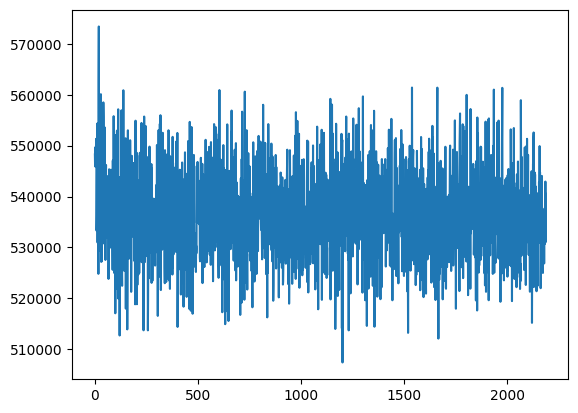

In [12]:
sns.lineplot(loss_list[20:])


In [39]:
## Train the model
learning_rate=1e-3
alpha = 0.99
momentum = 0.2

batch_size=128
num_epochs=10
hidden_dim_enc=4096
hidden_dim_dec= 1024
latent_dim=256

print(f"Using device:{device}")
# Define the VAE model
model = VAE(x_dim=X.shape[1], hidden_dim_enc=hidden_dim_enc, hidden_dim_dec=hidden_dim_dec, z_dim=latent_dim)
model = model.to(device)


# Define the optimizer
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha = alpha, momentum=momentum)


Using device:cuda:0


In [41]:
archs4_train = IsoDatasets.Archs4GeneExpressionDataset("/dtu-compute/datasets/iso_02456/hdf5/")

archs4_train_dataloader = DataLoader(archs4_train, batch_size=batch_size, shuffle=True)

In [44]:
# List with all of the loss
loss_list = list()
epochnum = num_epochs
epoch = 0
kl_loss = list()
while epoch < num_epochs:
    
    for X in tqdm(archs4_train_dataloader):   #tqdm(archs4_train_dataloader):
        # Zero the gradients
        X = X.to(device)
        optimizer.zero_grad()

        # Forward pass
        output, z, mu, logvar = model(X)

        # Calculate loss
        loss, kl = loss_function(output, X, mu, logvar)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        # Save loss
        loss_list.append(loss.item())
        kl_loss.append(kl)

    epoch += 1
    if epoch % 50 == 0:
        print(loss.item())



 21%|████████████████████████████████▍                                                                                                                      | 282/1312 [00:15<00:56, 18.25it/s]


KeyboardInterrupt: 

In [45]:
print(loss_list)

[538819.0, 537922.8125, 528546.375, 531485.1875, 537835.375, 529520.125, 541637.125, 530989.125, 538370.875, 526647.5, 542016.75, 547627.0, 534319.4375, 533168.3125, 528565.125, 525534.875, 530699.125, 537598.0, 528951.25, 540698.125, 535187.875, 532588.875, 543026.0, 549857.875, 545001.75, 541998.875, 535654.375, 540037.625, 539636.1875, 547371.625, 525926.8125, 541470.8125, 541504.4375, 535440.625, 531693.875, 532816.75, 537507.1875, 540445.5, 538890.6875, 547807.1875, 530095.3125, 540291.875, 521806.21875, 524732.625, 538061.8125, 551248.6875, 540807.375, 528326.125, 526435.25, 533468.5, 542202.375, 531882.125, 530982.25, 534056.5, 529743.6875, 530880.75, 535838.25, 530286.875, 529459.375, 535555.0, 530942.75, 536534.125, 520245.4375, 523085.6875, 539758.8125, 544802.9375, 533585.125, 536666.5625, 529730.75, 536864.375, 532743.625, 533270.875, 547109.875, 533623.25, 535779.0, 534383.375, 535178.875, 529651.5625, 529063.75, 524714.125, 536249.0, 523274.5625, 533012.625, 537867.5, 526

In [48]:
! pip install seaborn

distutils: /appl/python/3.11.4/include/python3.11/UNKNOWN
sysconfig: /appl/python/3.11.4/include/python3.11
user = False
home = None
root = None
prefix = None
Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)
distutils: /zhome/b6/d/154958/.local/include/python3.11/UNKNOWN
sysconfig: /zhome/b6/d/154958/.local/include/python3.11
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/appl/python/3.11.4/bin/python3.11 -m pip install --upgrade pip' command.


In [52]:
import pandas as pd
import matplotlib.pyplot

plt.figure()
plt.subplot(221)
sns.lineplot(loss_list)
#plt.subplot(222)
#sns.lineplot(kl_list[])


AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

In [110]:

kl_list = [x.cpu().detach().numpy().tolist() for x in kl_loss]

In [111]:
kl_list

[3234.77392578125,
 5680.54296875,
 1212.59912109375,
 291.20880126953125,
 75.43281555175781,
 58.82970428466797,
 32.604732513427734,
 51.21178436279297,
 30.51836395263672,
 17.25022315979004,
 26.300790786743164,
 34.43705749511719,
 15.780771255493164,
 25.44620132446289,
 22.3143310546875,
 4.936159610748291,
 1.129944086074829,
 5.552296161651611,
 0.9654097557067871,
 0.010571420192718506,
 2.871028184890747,
 1.784550666809082,
 1.4007091522216797e-05,
 3.032886266708374,
 0.0006855130195617676,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 1.1146068572998047e-05,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0